In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder

from sklearn import tree
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from itertools import product
from sklearn.ensemble import RandomForestRegressor
import os
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from skfeature.function.similarity_based import fisher_score
from sklearn.preprocessing import MinMaxScaler
from boruta import BorutaPy as bp

In [93]:
os.chdir("C:/Users/micha/OneDrive/Dokumenty/GitHub/Machine_Learning_Regression/Machine_Learning_Regression")

df = pd.read_csv('data/output/df_train.csv', index_col=0)
df_test = pd.read_csv('data/output/df_test.csv', index_col=0)


df.sample(10)

,mother_body_mass_index,mother_marital_status,mother_delivery_weight,mother_race,mother_height,mother_weight_gain,father_age,father_education,cigarettes_before_pregnancy,prenatal_care_month,number_prenatal_visits,previous_cesarean,newborn_gender,newborn_weight
1563032,24.4,2.0,199.0,1,67.0,43.0,32.0,9,40.0,6,2.0,N,M,2930
1610990,23.0,0.0,156.0,1,63.0,26.0,32.0,7,0.0,2,13.0,N,F,3210
1762764,32.2,2.0,213.0,1,63.0,31.0,39.0,3,0.0,2,13.0,N,F,3507
1959634,31.0,1.0,168.0,1,61.0,4.0,33.0,3,0.0,2,6.0,N,M,1049
1645119,22.0,1.0,181.0,1,68.0,29.0,38.0,7,0.0,3,13.0,N,F,3410
1331826,30.2,1.0,169.0,1,62.0,4.0,40.0,3,0.0,2,10.0,N,F,2665
500409,33.6,2.0,229.0,3,64.0,33.0,23.0,3,0.0,5,11.0,N,M,3850
389737,30.9,1.0,182.0,4,62.0,13.0,40.0,7,0.0,2,7.0,N,M,3370
1850370,20.2,1.0,155.0,1,63.0,41.0,34.0,8,0.0,2,14.0,N,M,3720
1976194,34.9,1.0,228.0,1,66.0,12.0,27.0,7,0.0,3,11.0,N,F,3061


## Transforming variables

Delete maybe weight, use more of the weight gain, may be more important. USE BMI, we can factorise it
Need to hot encode:
* mother_marital_status
* mother_race
* father_education
* parental_care_month
* previous_cesarean
* newborn_gender

In [94]:
def quick_viz(x):
    # create a figure with a histogram of x
    plt.figure(figsize=(10, 5))
    sns.histplot(data=x, kde=False, bins=50)
    plt.plot()

    # create a figure with a boxplot of x
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=x)
    plt.plot()

    # create a figure with a scatterplot of x and df.etr
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=x, y=df['newborn_weight'])
    plt.plot()

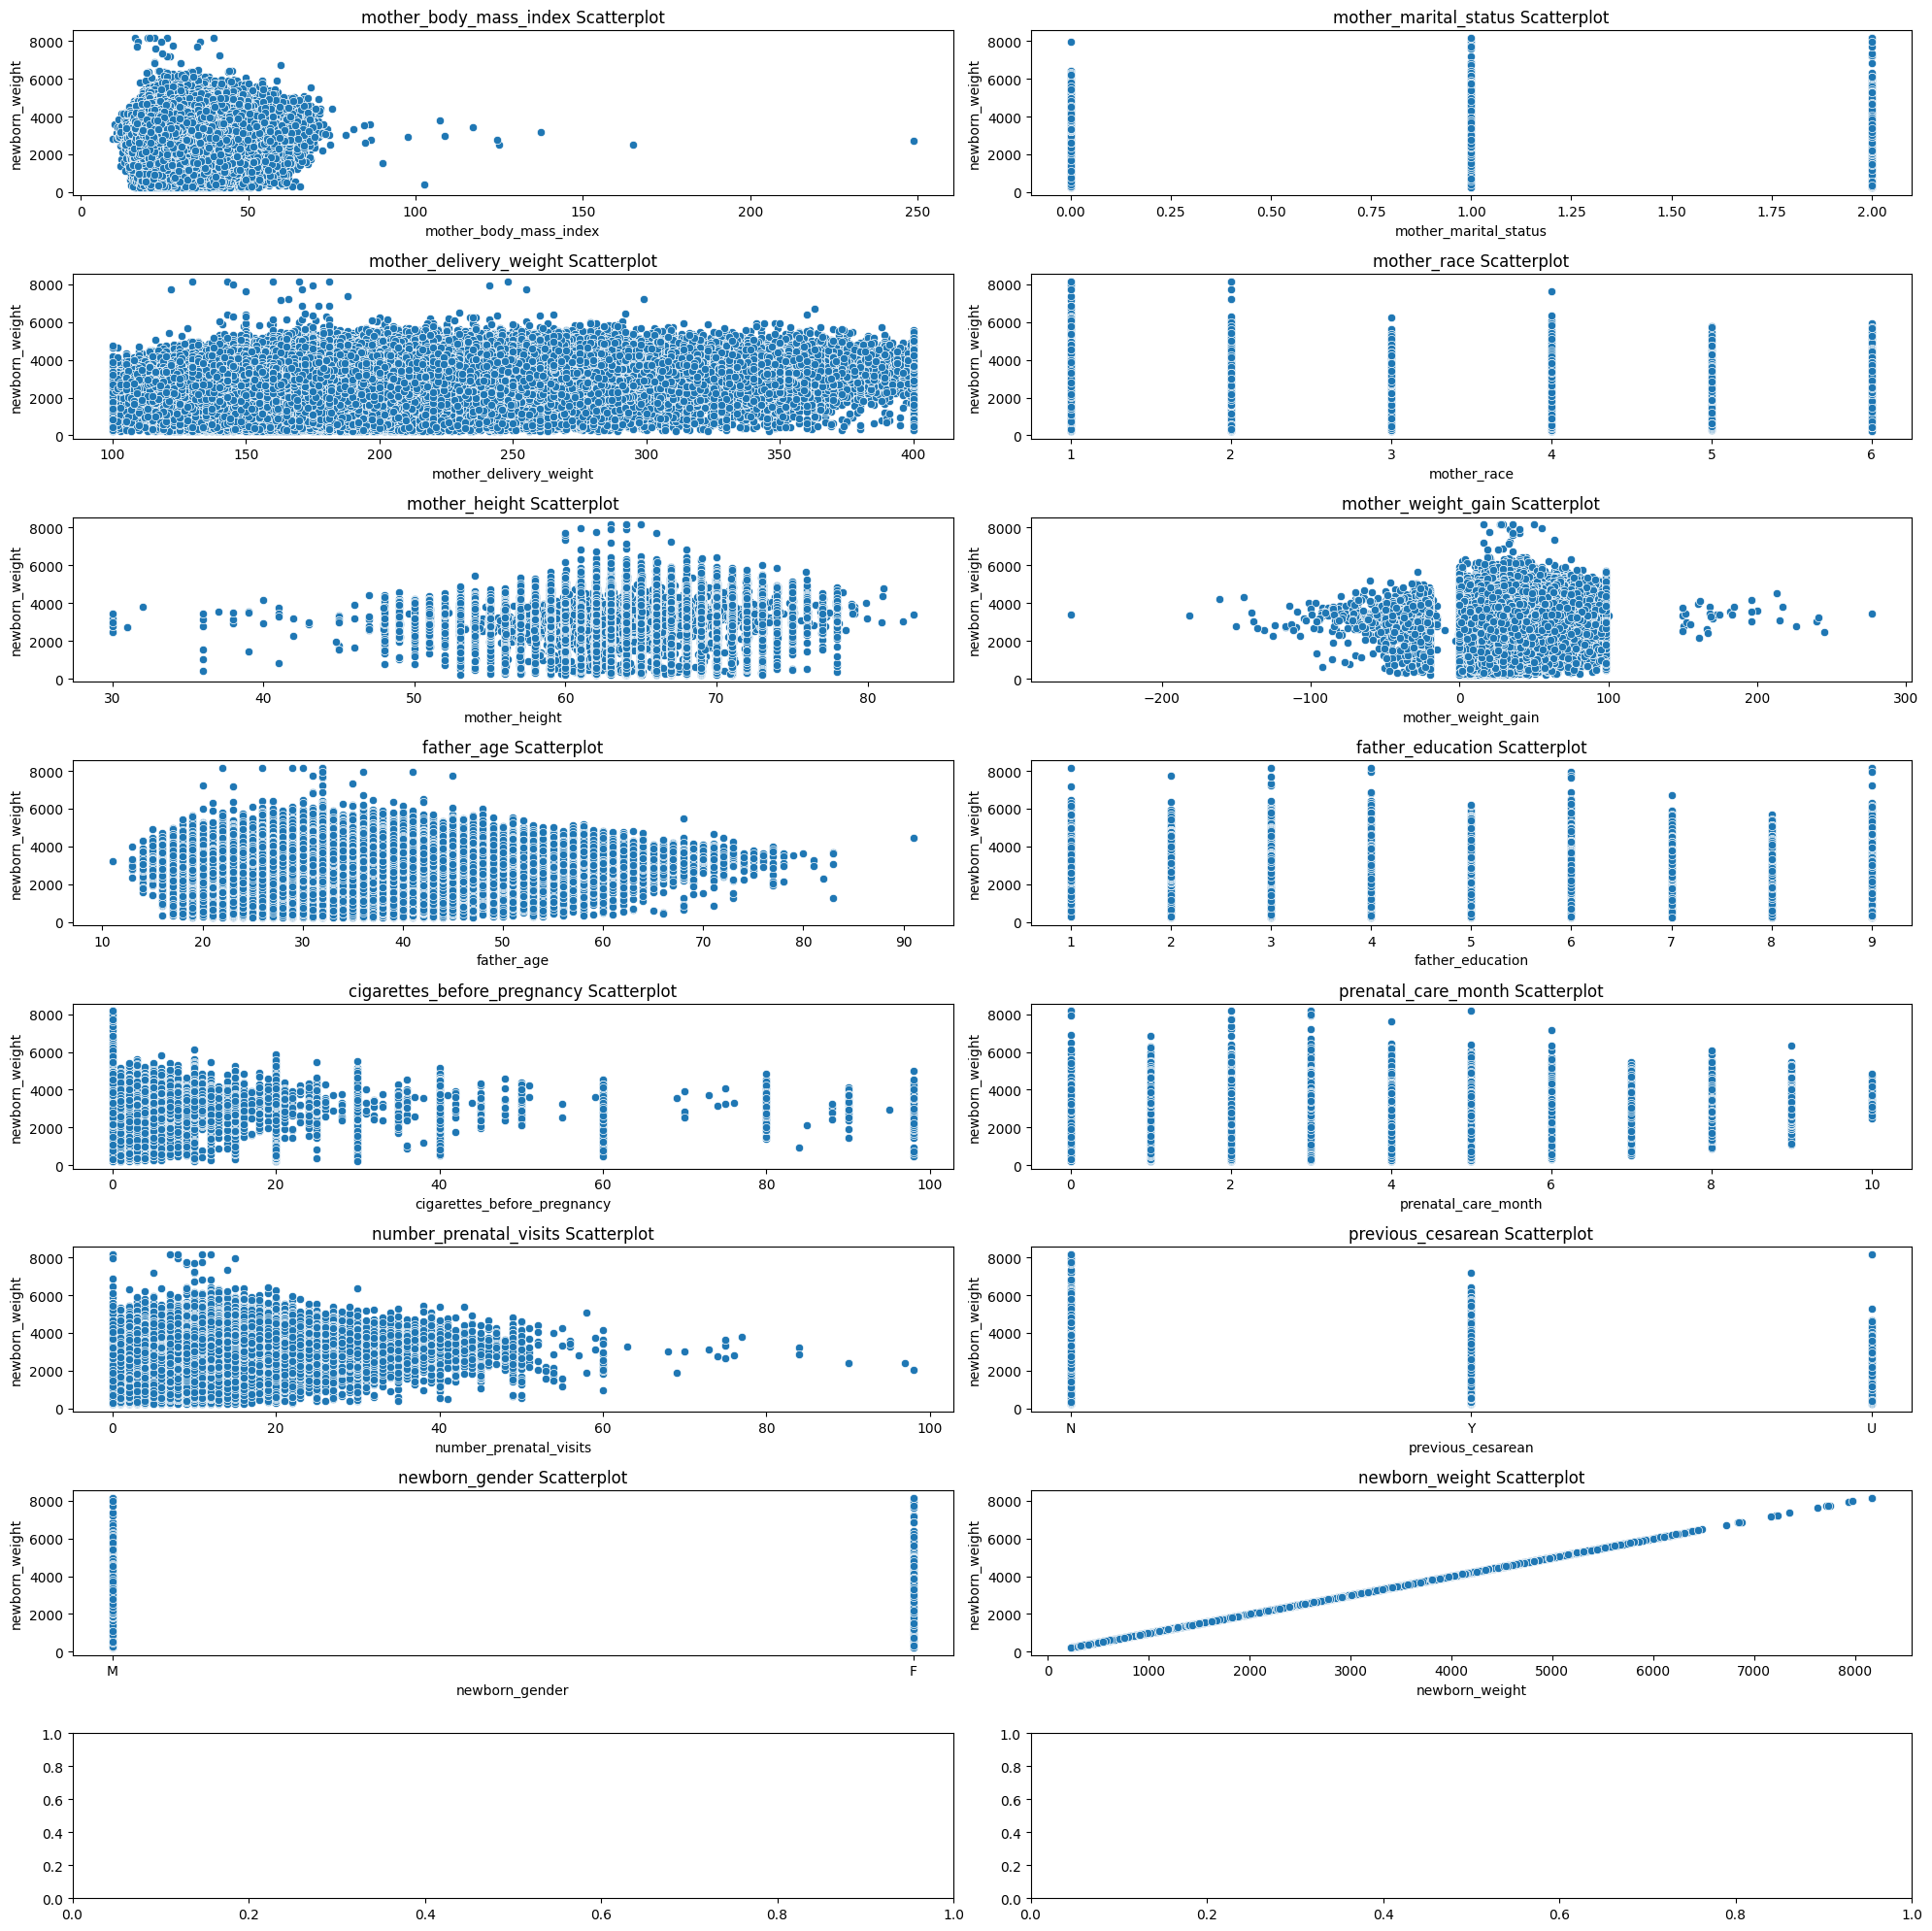

In [95]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)

axes = axes.flatten()

columns = df.columns

for i, column in enumerate(columns):

    ax = axes[i]
    sns.scatterplot(data=df, x=column, y='newborn_weight', ax=ax)
    ax.set_title(column + " Scatterplot")
    ax.set_xlabel(column)
    ax.set_ylabel("newborn_weight")

plt.tight_layout()
plt.show()

### Deleting outliers

Log Transformation & Deleting outliers

In [96]:
df.loc[df['mother_body_mass_index'] > 80, 'mother_body_mass_index'] = 80
df.loc[df['number_prenatal_visits'] > 60, 'number_prenatal_visits'] = 60
df.loc[df['father_age'] > 80, 'father_age'] = 80
df.loc[df['mother_height'] < 45, 'mother_height'] = 45
df['mother_delivery_weight_log'] = np.log(df['mother_delivery_weight'])
df['mother_body_mass_index_log'] = np.log(df['mother_body_mass_index'])

### Hot encoding

In [97]:
def feature_engineering(df):

    df.loc[df['mother_body_mass_index'] > 80, 'mother_body_mass_index'] = 80
    df.loc[df['number_prenatal_visits'] > 60, 'number_prenatal_visits'] = 60
    df.loc[df['father_age'] > 80, 'father_age'] = 80
    df.loc[df['mother_height'] < 45, 'mother_height'] = 45
    df['mother_delivery_weight'] = np.log(df['mother_delivery_weight'])
    df['mother_body_mass_index'] = np.log(df['mother_body_mass_index'])

    df = pd.get_dummies(df, columns=['mother_marital_status'], drop_first=True)
    df.rename(columns={'mother_marital_status_1.0': 'mother_marital_status_married', 
              'mother_marital_status_2.0': 'mother_marital_status_not_married'}, inplace=True)
    df['mother_marital_status_married'] = df['mother_marital_status_married'].astype(bool)
    df['mother_marital_status_not_married'] = df['mother_marital_status_not_married'].astype(bool)
    
    race_mapping = {
        2: 'Black',
        3: 'AIAN',
        4: 'Asian',
        5: 'NHOPI',
        6: '>1_race'
    }

    df = pd.get_dummies(df, columns=['mother_race'], drop_first=True)
    df.rename(columns={f"mother_race_{i}": race_mapping[i] for i in race_mapping.keys()}, inplace=True)
    df['Black'] = df['Black'].astype(bool)
    df['AIAN'] = df['AIAN'].astype(bool)
    df['Asian'] = df['Asian'].astype(bool)
    df['NHOPI'] = df['NHOPI'].astype(bool)
    df['>1_race'] = df['>1_race'].astype(bool)


    education_mapping = {
        1: 1,
        2: 1,
        3: 2,
        4: 2,
        5: 2,
        6: 3,
        7: 3,
        8: 4,
        9: 0
    }
    df['father_education'] = df['father_education'].map(education_mapping)

    #df['prenatal_care_month'] = df['prenatal_care_month'].replace([1, 2, 3], 1)
    #df['prenatal_care_month'] = df['prenatal_care_month'].replace([4, 5, 6], 2)
    #df['prenatal_care_month'] = df['prenatal_care_month'].replace([7, 8, 9, 10], 3)
    #encoded_columns = pd.get_dummies(df['prenatal_care_month'], prefix='prenatal_care')
    #encoded_columns.columns = encoded_columns.columns.str.replace('prenatal_care_', 'prenatal_care_')
    #df = pd.concat([df, encoded_columns], axis=1)

    df['previous_cesarean'] = df['previous_cesarean'].map({'Y': 1, 'N': 0, 'U': 0}).astype(bool)

    df['newborn_gender'] = (df['newborn_gender'] == 'M').astype(bool)

    df['smoker'] =(df['cigarettes_before_pregnancy'] > 0).astype(bool)
    

    return df



In [98]:
df_test = feature_engineering(df_test)
df = feature_engineering(df)

In [99]:
df = df.reset_index(drop=True)


In [100]:
num_missing = df.isna().sum()
num_missing = num_missing[num_missing > 0]

percent_missing = num_missing * 100 / df.shape[0]
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)


,Missing Values,Percentage


In [101]:
#quick_viz(df['mother_body_mass_index'])

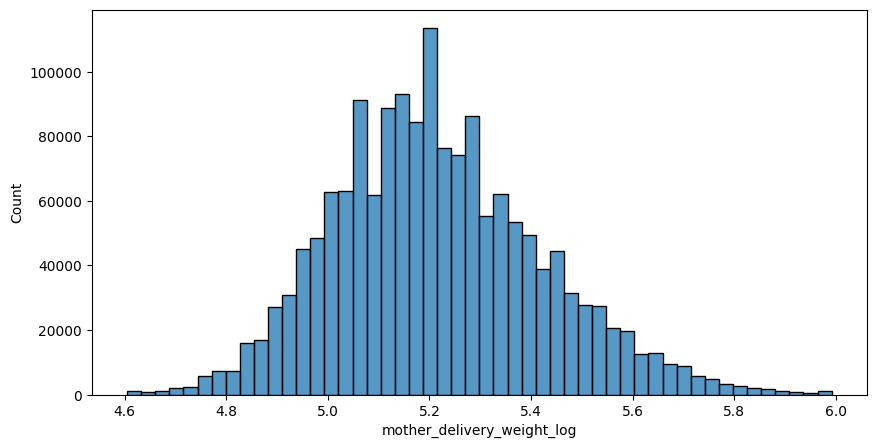

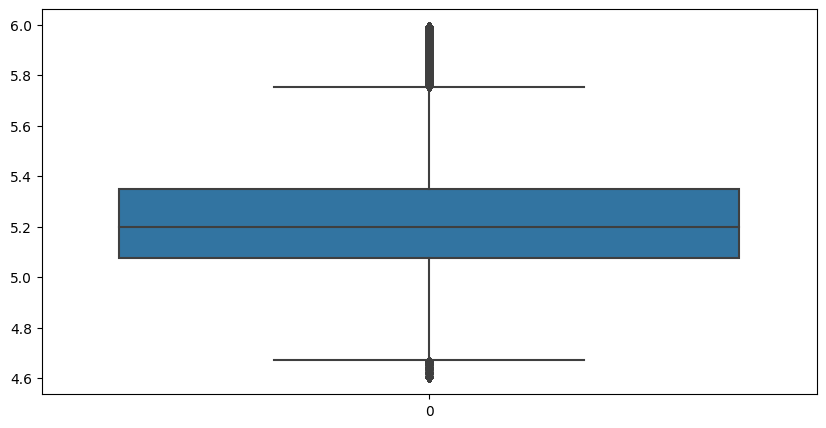

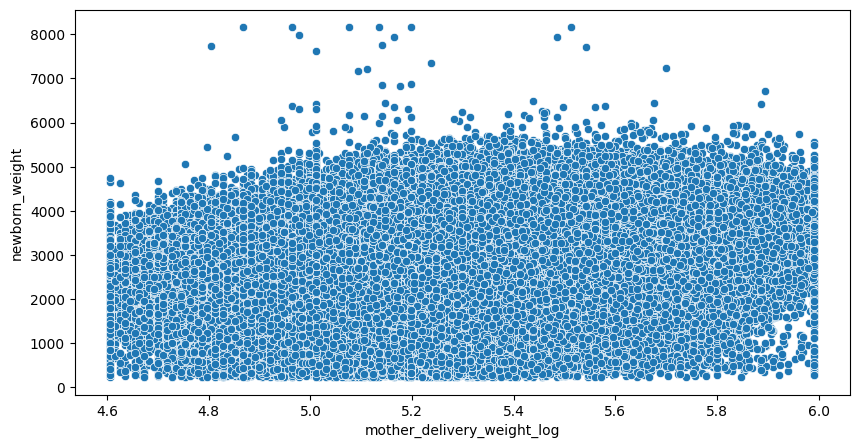

In [102]:
quick_viz(df['mother_delivery_weight_log'])

## Feature Selection

### Sampling the data

In [103]:
df.columns

Index(['mother_body_mass_index', 'mother_delivery_weight', 'mother_height',
       'mother_weight_gain', 'father_age', 'father_education',
       'cigarettes_before_pregnancy', 'prenatal_care_month',
       'number_prenatal_visits', 'previous_cesarean', 'newborn_gender',
       'newborn_weight', 'mother_delivery_weight_log',
       'mother_body_mass_index_log', 'mother_marital_status_married',
       'mother_marital_status_not_married', 'Black', 'AIAN', 'Asian', 'NHOPI',
       '>1_race', 'smoker'],
      dtype='object')

In [104]:
y_col = ['newborn_weight']

In [105]:
x_col = ['mother_body_mass_index', 'mother_delivery_weight', 'mother_height',
       'mother_weight_gain', 'father_age', 'father_education',
       'cigarettes_before_pregnancy', 'prenatal_care_month',
       'number_prenatal_visits', 'previous_cesarean', 'newborn_gender',
       'mother_delivery_weight_log',
       'mother_body_mass_index_log', 'mother_marital_status_married',
       'mother_marital_status_not_married', 'Black', 'AIAN', 'Asian', 'NHOPI',
       '>1_race', 'smoker']

In [106]:
df = df.sample(n=500000, random_state=42)
df = df.reset_index(drop=True)

In [107]:
scaler = MinMaxScaler()
df_re = pd.DataFrame(scaler.fit_transform(df.loc[:, x_col]), columns = x_col)

In [108]:
df_re = pd.DataFrame(StandardScaler().fit_transform(df.loc[:, x_col]), columns=x_col)


In [109]:
#df = df.drop('newborn_weight', axis=1)
df = pd.concat([df_re, df[y_col]], axis=1)

In [110]:
df.columns

Index(['mother_body_mass_index', 'mother_delivery_weight', 'mother_height',
       'mother_weight_gain', 'father_age', 'father_education',
       'cigarettes_before_pregnancy', 'prenatal_care_month',
       'number_prenatal_visits', 'previous_cesarean', 'newborn_gender',
       'mother_delivery_weight_log', 'mother_body_mass_index_log',
       'mother_marital_status_married', 'mother_marital_status_not_married',
       'Black', 'AIAN', 'Asian', 'NHOPI', '>1_race', 'smoker',
       'newborn_weight'],
      dtype='object')

In [111]:
df['newborn_weight']

0         2951
1         3506
2         3015
3         3141
4         4045
          ... 
499995    2551
499996    3105
499997    2780
499998    3317
499999    3409
Name: newborn_weight, Length: 500000, dtype: int64

In [112]:
df.dtypes

mother_body_mass_index               float64
mother_delivery_weight               float64
mother_height                        float64
mother_weight_gain                   float64
father_age                           float64
father_education                     float64
cigarettes_before_pregnancy          float64
prenatal_care_month                  float64
number_prenatal_visits               float64
previous_cesarean                    float64
newborn_gender                       float64
mother_delivery_weight_log           float64
mother_body_mass_index_log           float64
mother_marital_status_married        float64
mother_marital_status_not_married    float64
Black                                float64
AIAN                                 float64
Asian                                float64
NHOPI                                float64
>1_race                              float64
smoker                               float64
newborn_weight                         int64
dtype: obj

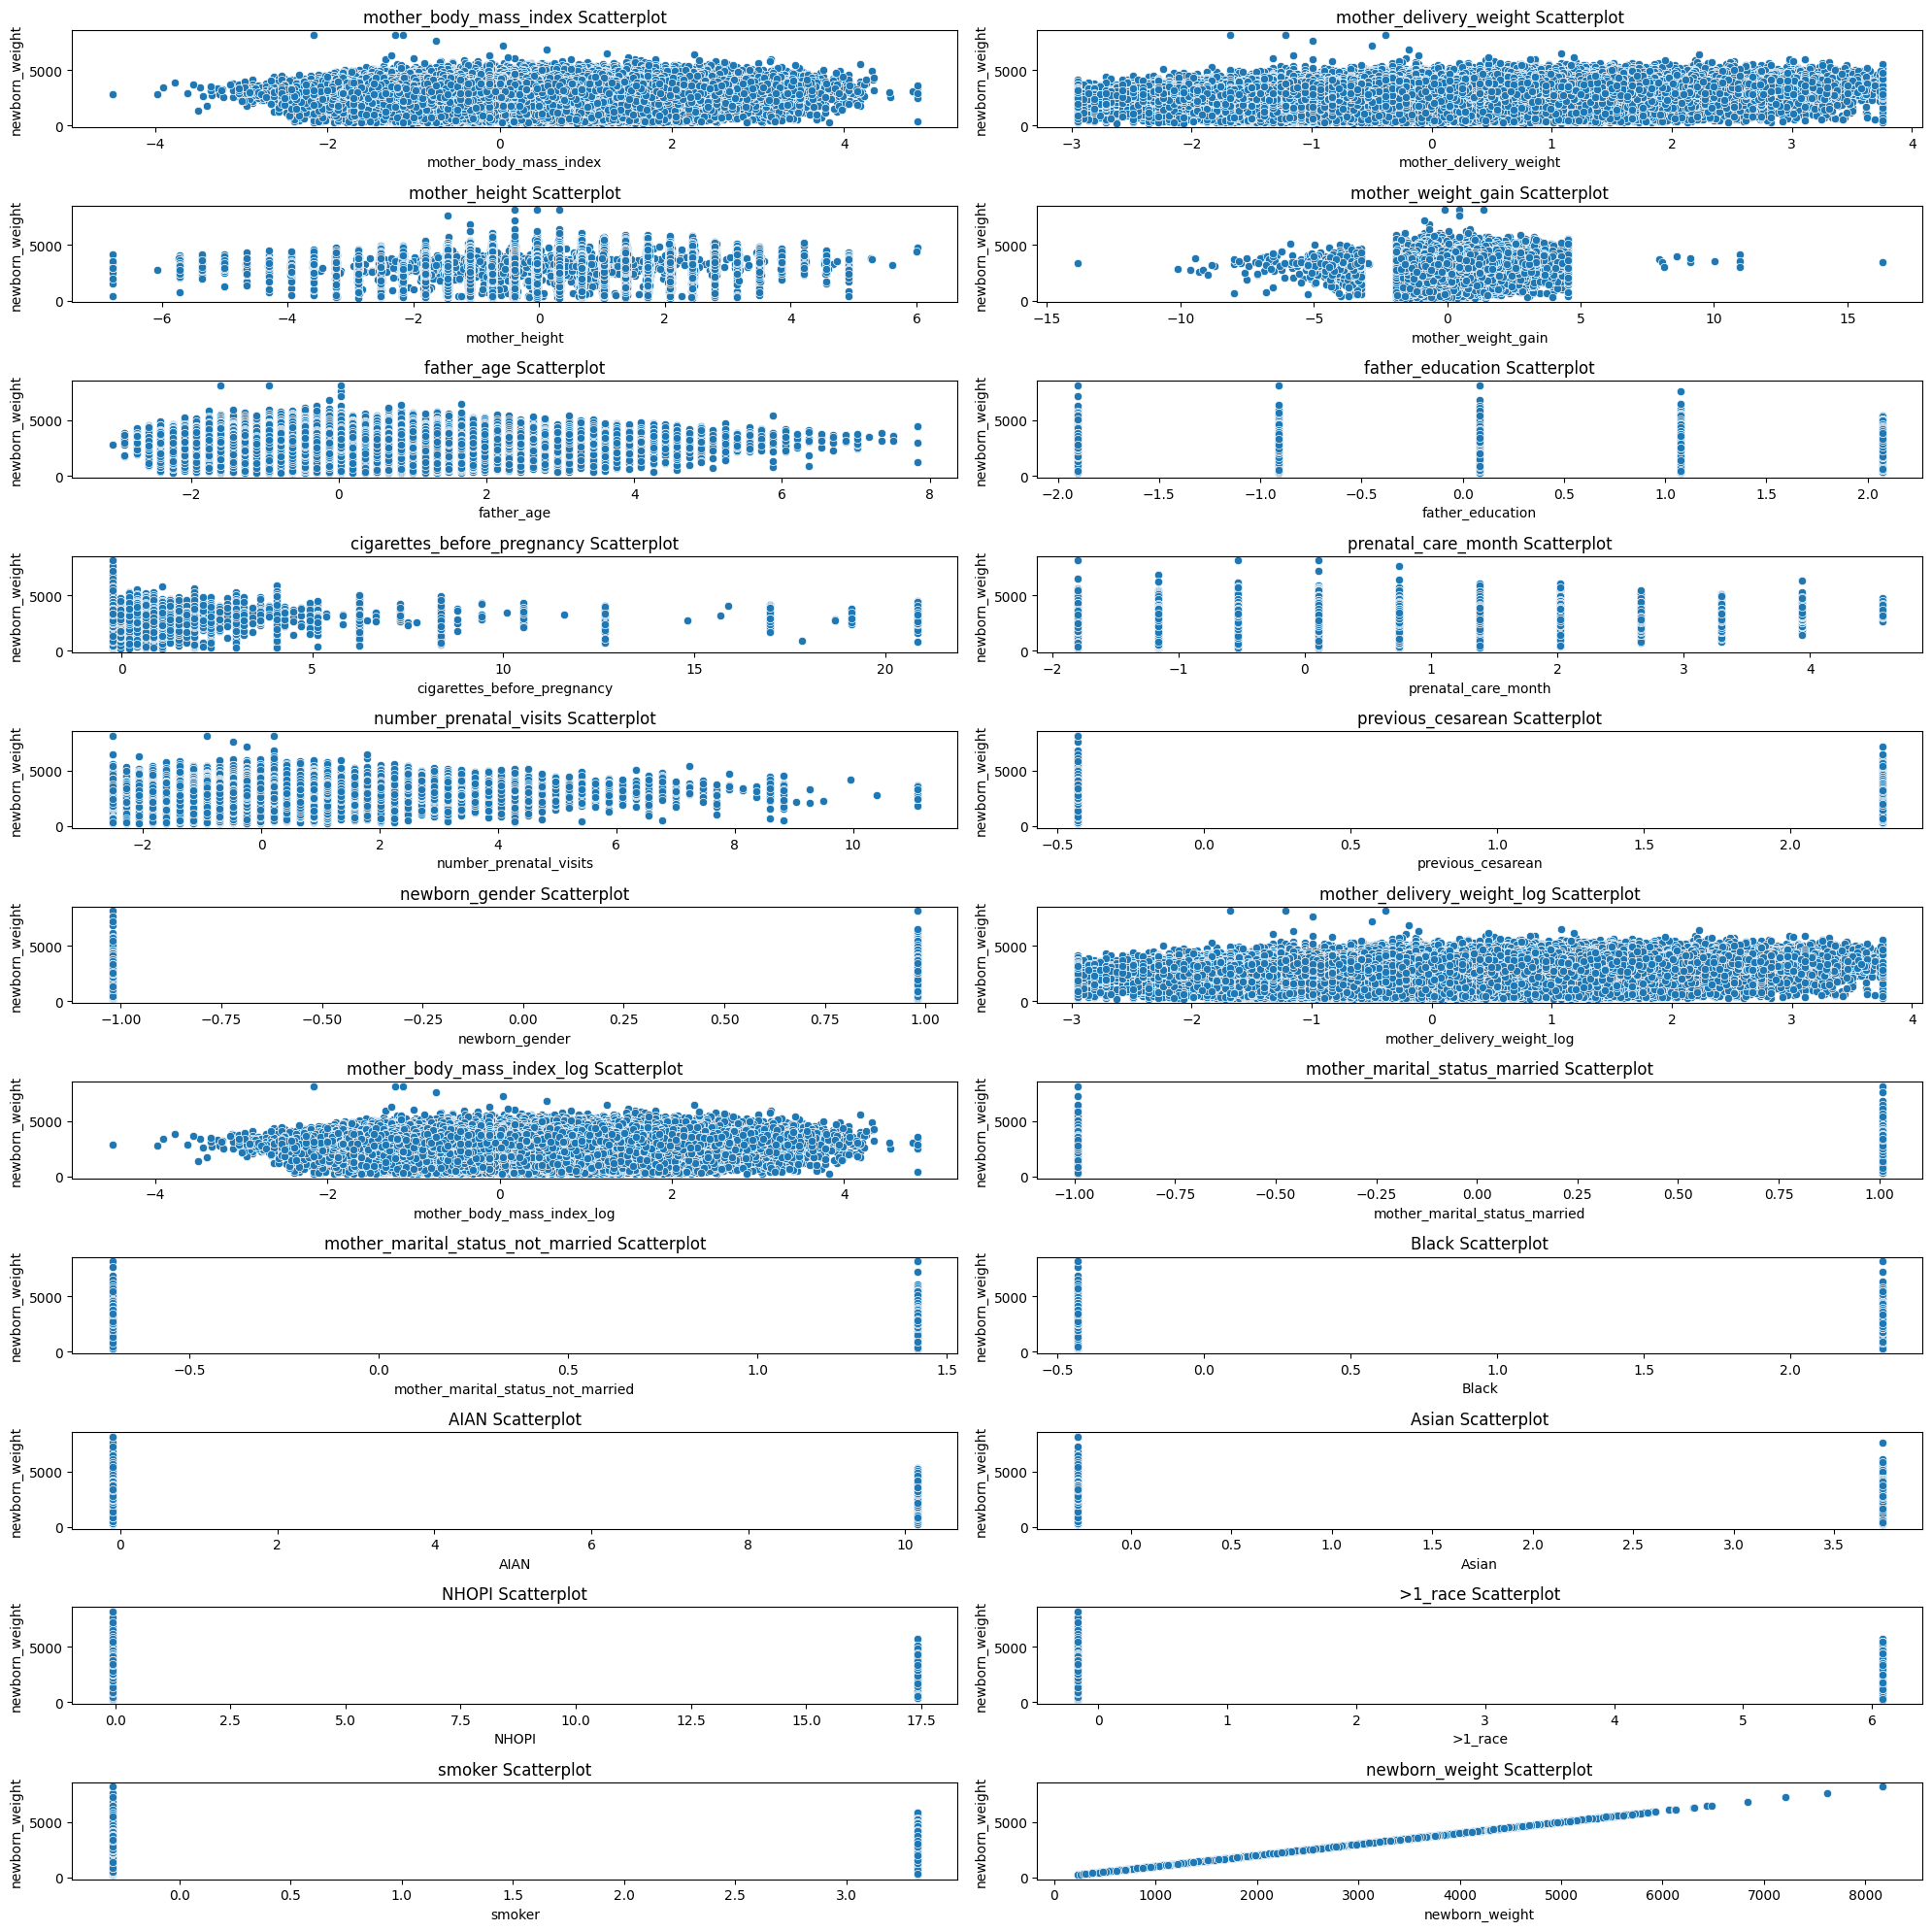

In [113]:
fig, axes = plt.subplots(nrows=11, ncols=2, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)

axes = axes.flatten()

columns = df.columns

for i, column in enumerate(columns):

    ax = axes[i]
    sns.scatterplot(data=df, x=column, y='newborn_weight', ax=ax)
    ax.set_title(column + " Scatterplot")
    ax.set_xlabel(column)
    ax.set_ylabel("newborn_weight")

plt.tight_layout()
plt.show()

In [114]:
sel = VarianceThreshold(0.001)
sel_var = sel.fit_transform(df[x_col])
col_imp = df[x_col][df[x_col].columns[sel.get_support(indices=True)]].columns
col_redundant = set(df[x_col].columns.tolist()) - set(col_imp)


In [115]:
general_ranking = pd.DataFrame(index=x_col)

In [116]:
#sel_ = SelectFromModel(Lasso(alpha=0.005, random_state=10))
#sel_.fit(df[x_col], df[y_col])
#sel_.get_feature_names_out()

## Correlation

<Axes: >

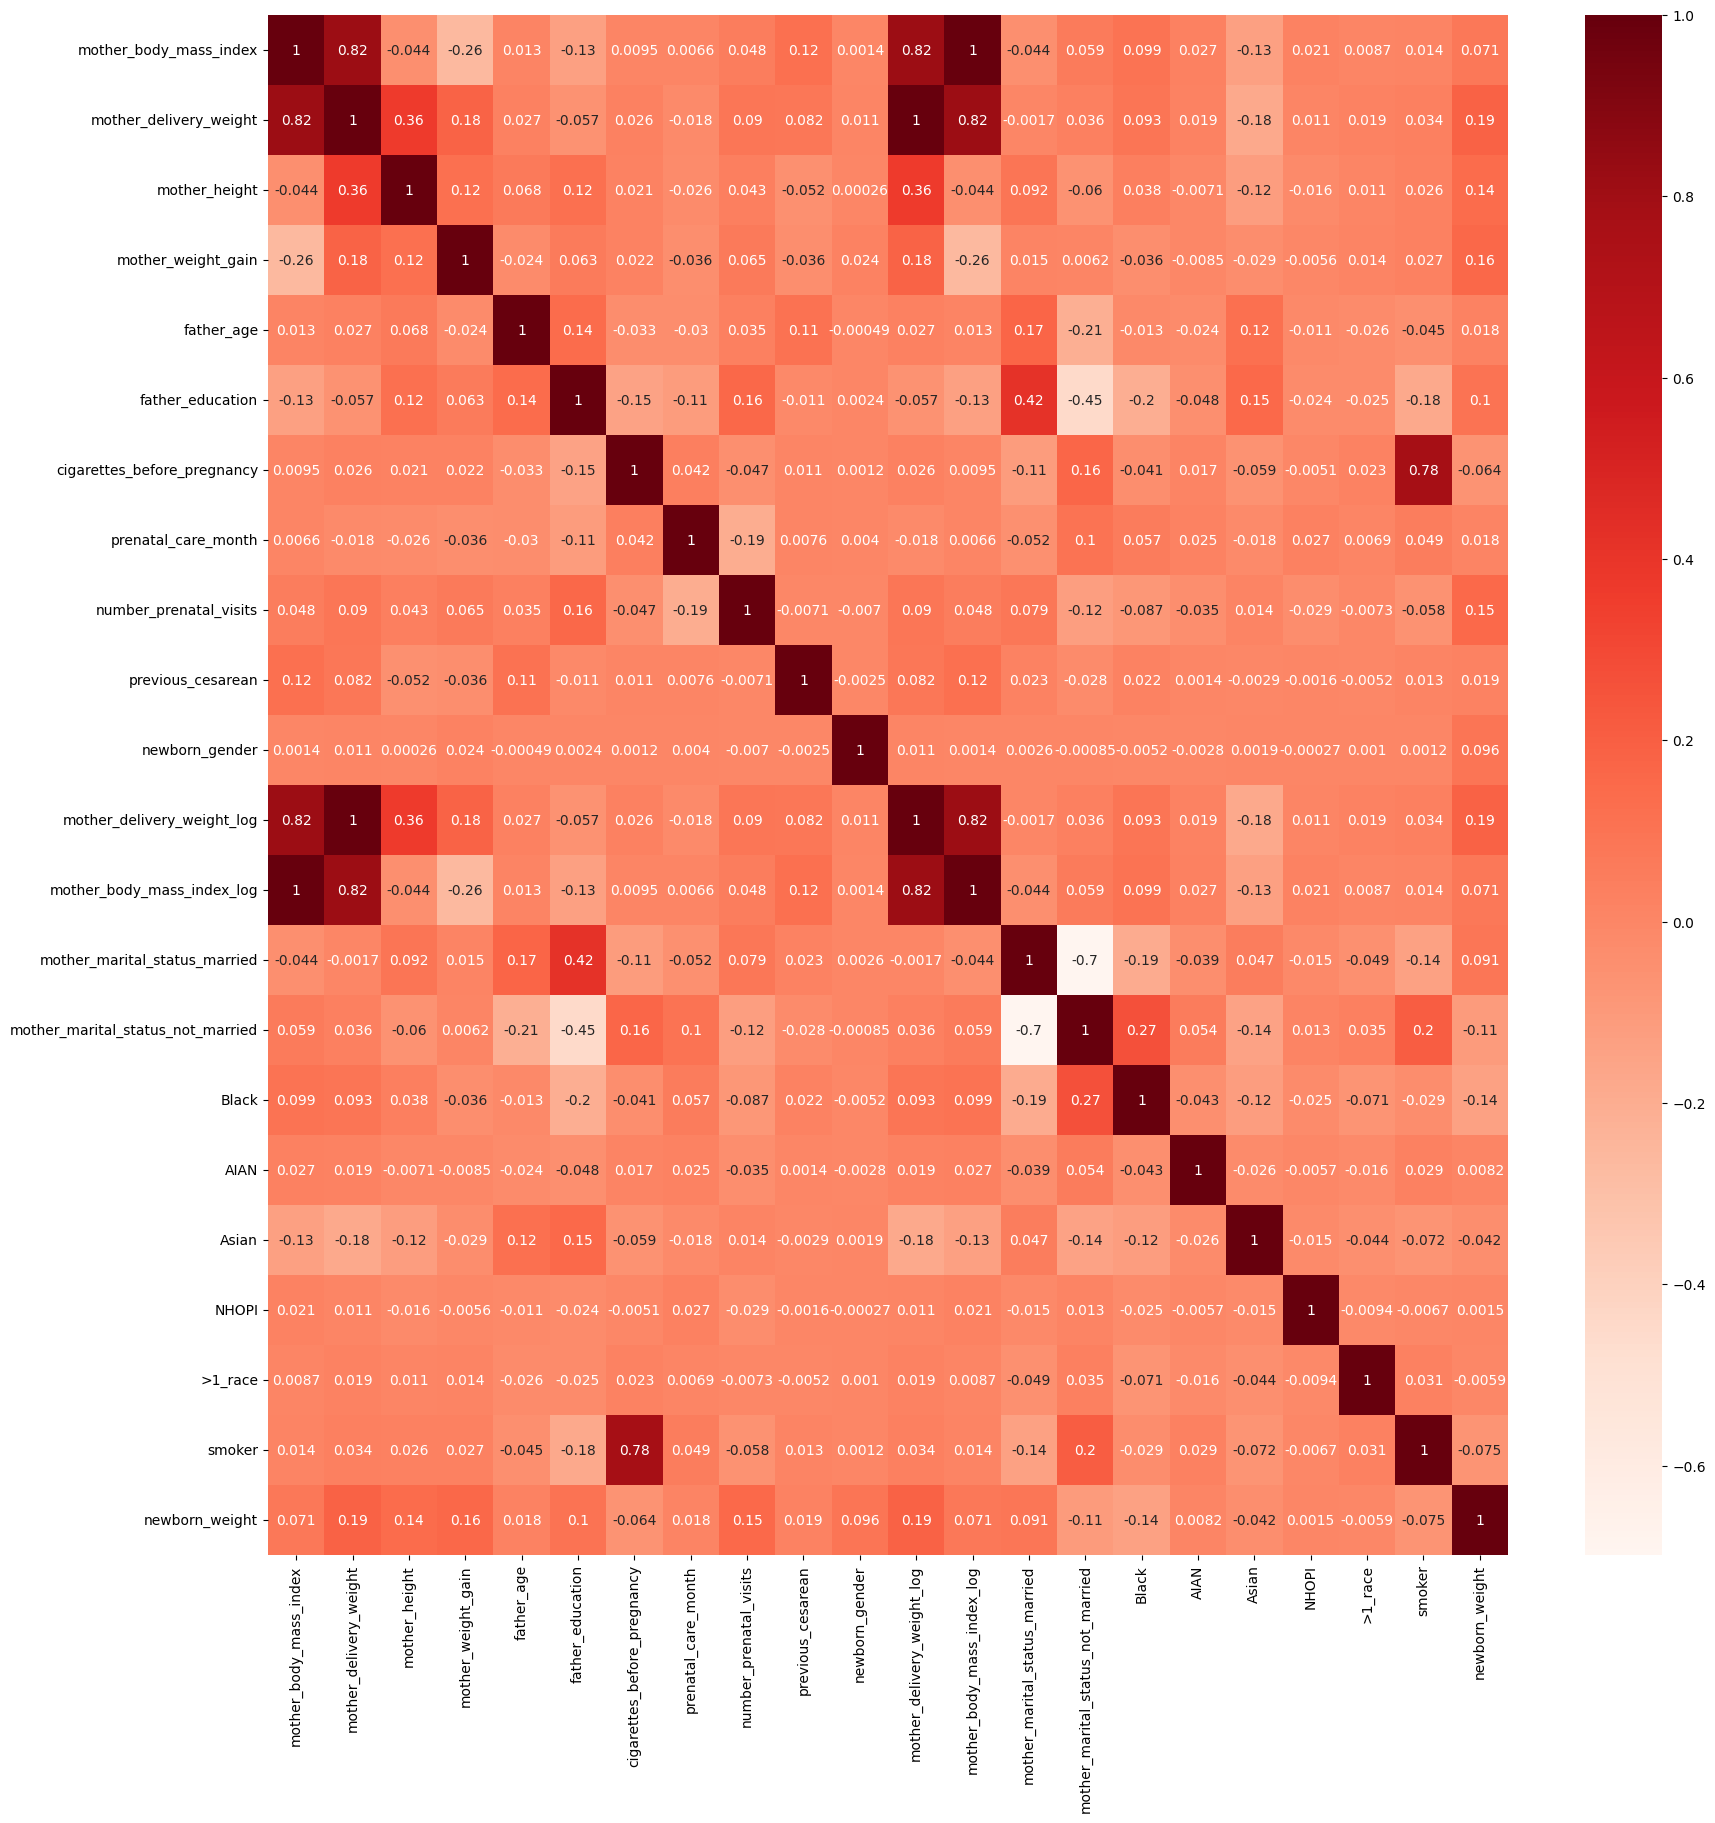

In [117]:
cor = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

### Mutual information

In [118]:
mi = dict()
for i in x_col:
    mi.update({i: mutual_info_regression(df[[i]].values, df[y_col].values.ravel())[0]})

In [119]:
miDF = pd.DataFrame.from_dict(mi, orient="index", columns=["score"])

In [120]:
miDF.sort_values(by="score").head(10)

,score
NHOPI,0.000000
AIAN,0.000000
>1_race,0.000370
previous_cesarean,0.001150
Asian,0.002784
cigarettes_before_pregnancy,0.003369
smoker,0.004565
father_age,0.004791
mother_marital_status_not_married,0.005045
prenatal_care_month,0.005405


In [121]:
miDF.sort_values(by="score", ascending=False).head(10)

,score
mother_delivery_weight,0.037620
mother_delivery_weight_log,0.035307
number_prenatal_visits,0.023873
mother_weight_gain,0.021361
mother_height,0.016931
mother_body_mass_index_log,0.013142
Black,0.011625
mother_body_mass_index,0.010817
newborn_gender,0.008175
mother_marital_status_married,0.007409


In [122]:
general_ranking = pd.merge(general_ranking, miDF, left_index=True, right_index=True)
general_ranking.rename(columns={"score": "mi_score"}, inplace=True)

### F-score

In [123]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
fscore = dict()
for i in x_col:
    fscore.update({i: f_regression(df[[i]].values, df[y_col].values.ravel())[1]})

In [124]:
fscoreDF = pd.DataFrame.from_dict(fscore, orient="index", columns=["p_value_score"])
fscoreDF.sort_values(by="p_value_score").head(10)

,p_value_score
mother_body_mass_index,0.0
Black,0.0
mother_marital_status_not_married,0.0
mother_marital_status_married,0.0
mother_body_mass_index_log,0.0
mother_delivery_weight_log,0.0
number_prenatal_visits,0.0
newborn_gender,0.0
cigarettes_before_pregnancy,0.0
father_education,0.0


In [125]:
fscoreDF.sort_values(by="p_value_score", ascending=False).head(10)

,p_value_score
NHOPI,2.934688e-01
>1_race,2.967512e-05
AIAN,6.773657e-09
prenatal_care_month,2.491900e-35
father_age,4.845727e-38
previous_cesarean,3.354504e-39
Asian,1.302392e-189
mother_body_mass_index,0.000000e+00
mother_body_mass_index_log,0.000000e+00
Black,0.000000e+00


In [126]:
general_ranking = pd.merge(general_ranking, fscoreDF, left_index=True, right_index=True)

In [127]:
general_ranking.rename(
    columns={"p_value_score": "sign_fscore", "sign": "sign_fscore_0_1"}, inplace=True
)

### Boruta

In [128]:
rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
feat_selector = bp(rf, n_estimators="auto", verbose=2)


In [130]:
feat_selector.fit_transform(df.loc[:, x_col].values, df.loc[:, y_col].values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	6
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	6
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	6
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	3
Rejected: 	6
Iteration: 	12 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	6
Iteration: 	13 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	6
Iteration: 	14 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	6
Iteration: 	15 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	6
Iteration: 	16 / 100
Confirmed: 	13
Tentative: 	2
Rejected: 	6
I

array([[-0.08269681, -0.04249298, -0.7460157 , ..., -0.70339451,
        -0.43233393, -0.30132711],
       [-0.16348726, -0.04249298,  1.22882067, ..., -0.70339451,
        -0.43233393, -0.30132711],
       [-1.3938462 , -1.46175264, -1.33846662, ..., -0.70339451,
        -0.43233393, -0.30132711],
       ...,
       [-0.99079209, -0.39730789, -0.61435995, ..., -0.70339451,
        -0.43233393, -0.30132711],
       [ 0.25258441, -0.04249298, -0.35104843, ..., -0.70339451,
        -0.43233393, -0.30132711],
       [-1.12144461, -0.04249298, -0.02190903, ..., -0.70339451,
        -0.43233393, -0.30132711]])

In [131]:
feat_selector.ranking_

array([3, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 2, 1, 1, 1, 6, 6, 6, 6, 1])

In [132]:
boruta_DF = pd.DataFrame(index=x_col)
boruta_DF["boruta_rank"] = feat_selector.ranking_

In [133]:
general_ranking = pd.merge(
    general_ranking, boruta_DF, left_index=True, right_index=True, how="left"
)

### ElasticNet

In [ ]:
#scaler = StandardScaler()
#df.loc[:, df.columns != 'newborn_weight'] = scaler.fit_transform(
#    df.loc[:, df.columns != 'newborn_weight'])

In [ ]:
def mape_cv(model, df):
    mape = cross_val_score(
            model,
            df.loc[:, x_col],
            df.loc[:, y_col],
            scoring='neg_mean_absolute_percentage_error',
            cv=5,
    )
    return mape

In [ ]:
alphas = [0.0001, 0.001, 0.01, 0.03]
l1_ratios = [1,0.8, 0.5, 0.3, 0.1]

In [ ]:
cv_elastic = [
    mape_cv(ElasticNet(alpha=alpha, l1_ratio=l1_ratio, tol = 0.5), df).mean()
    for (alpha, l1_ratio) in product(alphas, l1_ratios)
]

Text(0, 0.5, 'mape')

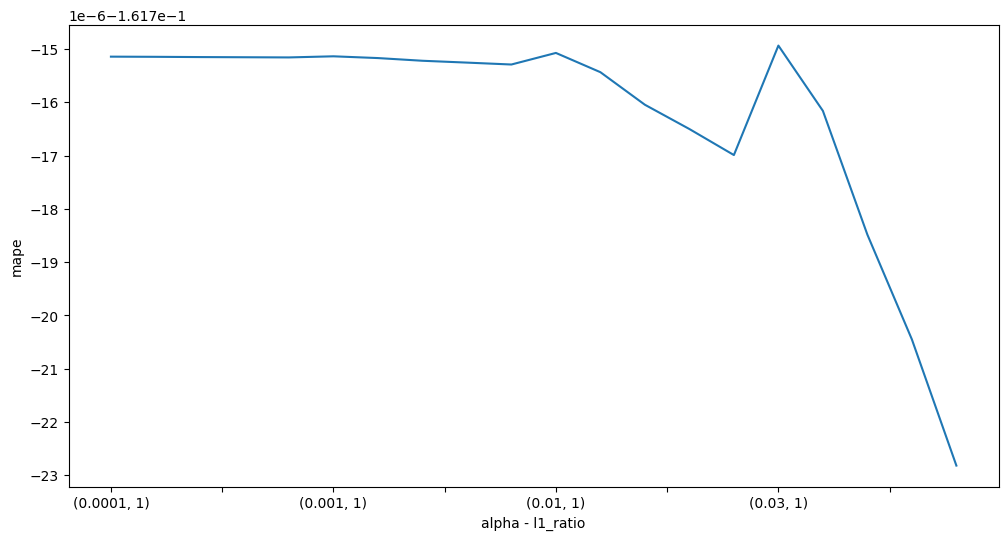

In [ ]:
plt.rcParams["figure.figsize"] = (12.0, 6.0)
idx = list(product(alphas, l1_ratios))
p_cv_elastic = pd.Series(cv_elastic, index=idx)
p_cv_elastic.plot()
plt.xlabel("alpha - l1_ratio")
plt.ylabel("mape")

In [ ]:
cv_elastic

[-0.16171514175972151,
 -0.16171514494034633,
 -0.16171514972920314,
 -0.16171515299802186,
 -0.1617151563060895,
 -0.1617151353298041,
 -0.16171516838763272,
 -0.1617152189385609,
 -0.16171525357489816,
 -0.1617152892891419,
 -0.16171507192710963,
 -0.1617154334962517,
 -0.16171604449590382,
 -0.1617165002432665,
 -0.16171698865078227,
 -0.16171493400524795,
 -0.16171615922853447,
 -0.1617184826070455,
 -0.16172044899948898,
 -0.1617228173091549]

In [ ]:
def run_elastic_net(sample_1):
    elastic = ElasticNet(alpha=1, l1_ratio=0.5)
    elastic.fit(sample_1.loc[:, x_col], sample_1.loc[:, y_col])
    coef = pd.Series(elastic.coef_, index=sample_1.loc[:, x_col].columns)
    print(
        "Elastic Net picked "
        + str(sum(coef != 0))
        + " variables and eliminated the other "
        + str(sum(coef == 0))
        + " variables"
    )
    return coef.sort_values()
    imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
    plt.rcParams["figure.figsize"] = (8.0, 10.0)
    imp_coef.plot(kind="barh")
    plt.title("Coefficients in the Elastic Net Model")
    plt.show()




Elastic Net picked 20 variables and eliminated the other 1 variables


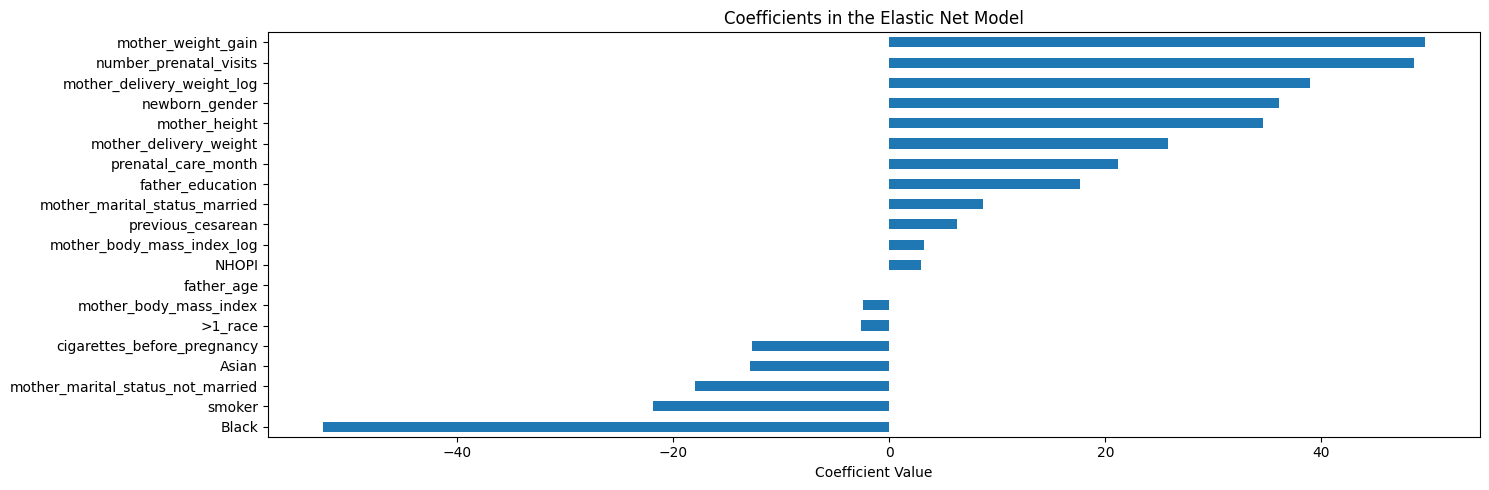

In [ ]:
coef = run_elastic_net(df)
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
fig, ax = plt.subplots(figsize=(15, 5))
imp_coef.plot(kind="barh", ax=ax)
ax.set_title("Coefficients in the Elastic Net Model")
ax.set_xlabel("Coefficient Value")

plt.tight_layout()
plt.show()

In [ ]:
coef = run_elastic_net(df)
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

Elastic Net picked 20 variables and eliminated the other 1 variables


In [ ]:
coefficients = pd.DataFrame()

# Run the Elastic Net and store the coefficients for each sample
for i, sample in enumerate(samples):
    coef = run_elastic_net(sample)
    coefficients['Sample ' + str(i+1)] = coef

# Calculate the mean of coefficients across the samples
mean_coefficients = coefficients.mean(axis=1)

# Plot the mean coefficients
plt.figure(figsize=(8, 6))
mean_coefficients.plot(kind="barh")
plt.title("Mean Coefficients across Samples")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

NameError: name 'samples' is not defined

In [ ]:
general_ranking = pd.merge(
    general_ranking,
    pd.DataFrame(imp_coef),
    left_index=True,
    right_index=True,
    how="left",
)

In [136]:
corr = list()
for i in x_col:
    corr.append(stats.spearmanr(df.loc[:, y_col].values, df.loc[:, i].values)[0])
    

In [140]:
general_ranking = pd.merge(
    general_ranking,
    pd.DataFrame(corr, index=x_col, columns=["corr"]),
    left_index=True,
    right_index=True,
)

In [141]:
pd.set_option("display.max_rows", 500)

In [142]:
general_ranking.sort_values(["mi_score","corr"], ascending=False)

,mi_score,sign_fscore,boruta_rank,corr
mother_delivery_weight,0.037620,0.000000e+00,1,0.211110
mother_delivery_weight_log,0.035307,0.000000e+00,1,0.211110
number_prenatal_visits,0.023873,0.000000e+00,1,0.149988
mother_weight_gain,0.021361,0.000000e+00,1,0.170464
mother_height,0.016931,0.000000e+00,1,0.158014
mother_body_mass_index_log,0.013142,0.000000e+00,2,0.090487
Black,0.011625,0.000000e+00,1,-0.135189
mother_body_mass_index,0.010817,0.000000e+00,3,0.090487
newborn_gender,0.008175,0.000000e+00,1,0.112184
mother_marital_status_married,0.007409,0.000000e+00,1,0.095450


In [ ]:
import openpyxl


In [143]:
general_ranking.to_excel("data/output/feature_ranking.xlsx")
df.to_csv("data/output/train_fe.csv")
df_test.to_csv("data/output/test_fe.csv")

